# Sign Language Recognition with RNN

This notebook trains an RNN model to recognize sign language from landmark data extracted using MediaPipe.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpu)
    except RuntimeError as e:
        print('error'+ e)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
from numba import cuda

cuda.select_device(0)
cuda.close()
cuda.select_device(0)


<weakproxy at 0x000002E815061F30 to Device at 0x000002E815058460>

## Load Preprocessed Data

In [4]:

# Load the combined CSV file into a DataFrame
# csv_file_path = 'D:/Projects/AIML/HandSign/Dataset_CSVs/transformed_data.csv'
csv_file_path = 'D:/Projects/AIML/HandSign/Dataset_CSVs/keypoints_data.csv'

df = pd.read_csv(csv_file_path)




In [5]:
print(df.head())

   face_0_x  face_0_y  face_1_x  face_1_y  face_2_x  face_2_y  face_3_x  \
0  0.480987  0.600960  0.486844  0.549152  0.483475  0.566798  0.479284   
1  0.515435  0.612552  0.521321  0.560277  0.517003  0.578228  0.511478   
2  0.499053  0.592653  0.503803  0.538680  0.500637  0.558055  0.494142   
3  0.437985  0.589782  0.439237  0.538740  0.438284  0.556461  0.429700   
4  0.420540  0.584587  0.419919  0.535113  0.419445  0.551029  0.408256   

   face_3_y  face_4_x  face_4_y  ...  pose_28_y  pose_29_x  pose_29_y  \
0  0.495447  0.488247  0.532376  ...   3.211675   0.699006   3.337574   
1  0.506666  0.522563  0.543482  ...   3.176484   0.687595   3.314011   
2  0.487191  0.504793  0.522018  ...   3.123261   0.685968   3.249211   
3  0.488853  0.439693  0.522769  ...   3.069936   0.615897   3.201243   
4  0.484223  0.419772  0.519081  ...   3.183950   0.663719   3.308161   

   pose_30_x  pose_30_y  pose_31_x  pose_31_y  pose_32_x  pose_32_y  label  
0   0.386315   3.310355   0.65276

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Columns: 1087 entries, face_0_x to label
dtypes: float64(1086), object(1)
memory usage: 1.5+ MB


In [7]:
df.shape

(183, 1087)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle



In [9]:
left_hand_columns = [col for col in df.columns if col.startswith('left_hand')]
right_hand_columns = [col for col in df.columns if col.startswith('right_hand')]
pose_columns = [col for col in df.columns if col.startswith('pose')]

# Ensure the data is in the correct shape (number_of_samples, number_of_frames, number_of_features_per_frame)
def reshape_data(df, columns, num_frames):
    data = df[columns].values
    num_samples = len(df) // num_frames
    data = data.reshape(num_samples, num_frames, len(columns))
    return data


# Assuming num_frames is known
num_frames = 1 # This should be the length of the time series

left_hand_data = reshape_data(df, left_hand_columns, num_frames)
right_hand_data = reshape_data(df, right_hand_columns, num_frames)
pose_data = reshape_data(df, pose_columns, num_frames)

In [10]:
print("Left hand data shape:", left_hand_data.shape)
print("Right hand data shape:", right_hand_data.shape)
print("Pose data shape:", pose_data.shape)

Left hand data shape: (183, 1, 42)
Right hand data shape: (183, 1, 42)
Pose data shape: (183, 1, 66)


In [11]:
num_frames

1

In [12]:
# Extract the labels and convert them to one-hot encoding if necessary
labels = df['label'].values[:len(df) // num_frames * num_frames]
labels = labels.reshape(len(labels) // num_frames, num_frames)[:, 0]  # Assuming one label per sample


In [13]:
labels.shape

(183,)

In [14]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse_output=False)
labels_onehot = onehot_encoder.fit_transform(labels_encoded.reshape(-1, 1))


# with open('Models/label_encoder_word.pkl', 'wb') as file:
#     pickle.dump(label_encoder, file)

with open('Models/label_encoder_letter.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [15]:


# Define input shapes for each branch
hand_input_shape = (num_frames, len(right_hand_columns))
pose_input_shape = (num_frames, len(pose_columns))





In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam

def create_multi_branch_model(hand_input_shape, pose_input_shape, number_of_classes, hand_units=50, pose_units=25):
    
    # Input layers for each set of features
    left_hand_input = Input(shape=hand_input_shape)
    right_hand_input = Input(shape=hand_input_shape)
    pose_input = Input(shape=pose_input_shape)
    
    
    # Left Hand branch
    left_hand_lstm = LSTM(units=hand_units)(left_hand_input)
    
    # Right Hand branch
    right_hand_lstm = LSTM(units=hand_units)(right_hand_input)
    
    # Pose branch
    pose_lstm = LSTM(units=pose_units)(pose_input)
    
    
    # Weighted combination of branches
    left_hand_output = Multiply()([left_hand_lstm, Dense(1, activation='linear', use_bias=False)(left_hand_lstm)])
    right_hand_output = Multiply()([right_hand_lstm, Dense(1, activation='linear', use_bias=False)(right_hand_lstm)])
    pose_output = Multiply()([pose_lstm, Dense(1, activation='linear', use_bias=False)(pose_lstm)])
    
    # Concatenate the outputs
    combined_output = Concatenate()([left_hand_output, right_hand_output, pose_output])
    
    # Final dense layer for classification
    final_output = Dense(units=number_of_classes, activation='softmax')(combined_output)
    
    model = Model(inputs=[left_hand_input, right_hand_input, pose_input], outputs=final_output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [17]:
number_of_classes = len(onehot_encoder.categories_[0])
model = create_multi_branch_model(hand_input_shape, pose_input_shape,  number_of_classes)



In [18]:
# Split data into training and validation sets
X_left_train, X_left_val, X_right_train, X_right_val, X_pose_train, X_pose_val, y_train, y_val = train_test_split(
    left_hand_data, right_hand_data, pose_data, labels_onehot, test_size=0.2, random_state=42)


In [19]:
history = model.fit([X_left_train, X_right_train, X_pose_train], y_train, epochs=200, batch_size=32,
                    validation_data=([X_left_val, X_right_val, X_pose_val], y_val))



# Evaluate the model
loss, accuracy = model.evaluate([X_left_val, X_right_val, X_pose_val], y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

Epoch 1/200
5/5 [==============================] - 32s 350ms/step - loss: 3.2959 - accuracy: 0.0137 - val_loss: 3.2946 - val_accuracy: 0.0000e+00
Epoch 2/200
5/5 [==============================] - 0s 34ms/step - loss: 3.2920 - accuracy: 0.0685 - val_loss: 3.2957 - val_accuracy: 0.0811
Epoch 3/200
5/5 [==============================] - 0s 34ms/step - loss: 3.2862 - accuracy: 0.1575 - val_loss: 3.2947 - val_accuracy: 0.0270
Epoch 4/200
5/5 [==============================] - 0s 32ms/step - loss: 3.2756 - accuracy: 0.1096 - val_loss: 3.2925 - val_accuracy: 0.0270
Epoch 5/200
5/5 [==============================] - 0s 32ms/step - loss: 3.2613 - accuracy: 0.0616 - val_loss: 3.2876 - val_accuracy: 0.0000e+00
Epoch 6/200
5/5 [==============================] - 0s 26ms/step - loss: 3.2352 - accuracy: 0.0548 - val_loss: 3.2819 - val_accuracy: 0.0270
Epoch 7/200
5/5 [==============================] - 0s 31ms/step - loss: 3.1972 - accuracy: 0.1027 - val_loss: 3.2730 - val_accuracy: 0.0270
Epoch 8/20

In [23]:

# Save the model
model.save('Models/sign_language_letter_model_2.h5')


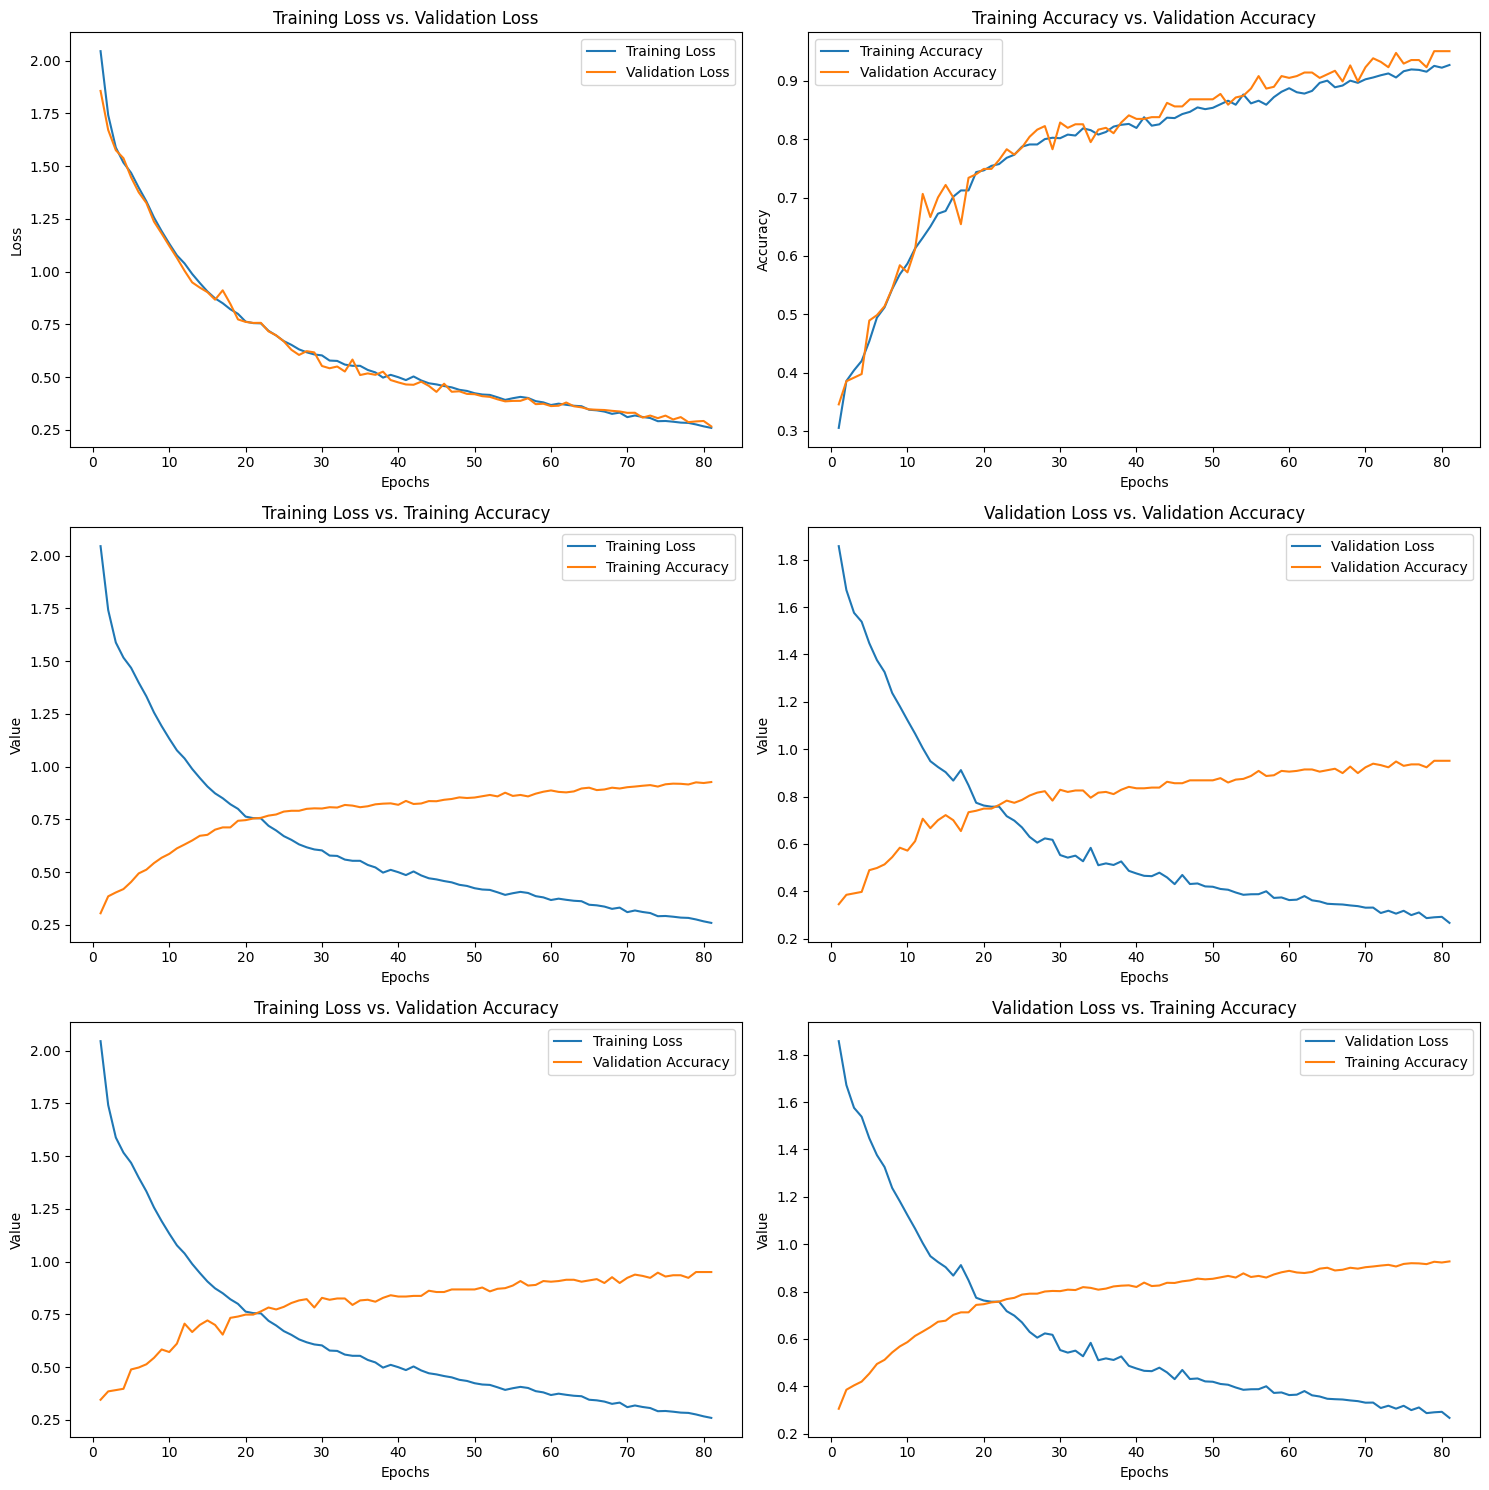

In [21]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
epochs = list(range(1, 82))  # Assuming 82 epochs based on the provided data
loss = [2.0453, 1.7424, 1.5885, 1.5169, 1.4686, 1.3984, 1.3336, 1.2569, 1.1924, 1.1331, 1.0775, 1.0393, 0.9894, 0.9466, 
        0.9062, 0.8737, 0.8506, 0.8220, 0.8002, 0.7634, 0.7563, 0.7552, 0.7199, 0.6977, 0.6710, 0.6533, 0.6318, 0.6180, 
        0.6078, 0.6033, 0.5788, 0.5771, 0.5597, 0.5540, 0.5539, 0.5344, 0.5226, 0.4980, 0.5111, 0.5000, 0.4863, 0.5035, 
        0.4846, 0.4712, 0.4658, 0.4580, 0.4518, 0.4402, 0.4348, 0.4240, 0.4179, 0.4160, 0.4047, 0.3924, 0.4003, 0.4067, 
        0.4015, 0.3864, 0.3806, 0.3681, 0.3745, 0.3691, 0.3646, 0.3624, 0.3457, 0.3429, 0.3370, 0.3262, 0.3321, 0.3106, 
        0.3185, 0.3114, 0.3064, 0.2914, 0.2924, 0.2890, 0.2847, 0.2833, 0.2760, 0.2670, 0.2597]  # Loss values

val_loss = [1.8569, 1.6717, 1.5757, 1.5380, 1.4473, 1.3761, 1.3256, 1.2372, 1.1811, 1.1224, 1.0655, 1.0046, 0.9494, 0.9247, 
            0.9030, 0.8674, 0.9117, 0.8476, 0.7739, 0.7621, 0.7572, 0.7576, 0.7173, 0.6984, 0.6699, 0.6298, 0.6055, 0.6234, 
            0.6175, 0.5531, 0.5423, 0.5506, 0.5269, 0.5836, 0.5102, 0.5179, 0.5113, 0.5262, 0.4865, 0.4753, 0.4655, 0.4640, 
            0.4787, 0.4588, 0.4304, 0.4691, 0.4309, 0.4332, 0.4208, 0.4193, 0.4100, 0.4067, 0.3951, 0.3854, 0.3876, 0.3879, 
            0.4002, 0.3722, 0.3742, 0.3631, 0.3648, 0.3800, 0.3621, 0.3571, 0.3475, 0.3457, 0.3444, 0.3405, 0.3375, 0.3310, 
            0.3314, 0.3085, 0.3181, 0.3058, 0.3179, 0.2996, 0.3108, 0.2869, 0.2904, 0.2924, 0.2668]  # Validation Loss values

accuracy = [0.3053, 0.3856, 0.4040, 0.4200, 0.4537, 0.4943, 0.5119, 0.5432, 0.5685, 0.5868, 0.6129, 0.6312, 0.6503, 0.6725, 
            0.6771, 0.7016, 0.7123, 0.7123, 0.7437, 0.7467, 0.7544, 0.7575, 0.7682, 0.7735, 0.7873, 0.7911, 0.7911, 0.8003, 
            0.8026, 0.8018, 0.8080, 0.8064, 0.8187, 0.8156, 0.8080, 0.8125, 0.8217, 0.8248, 0.8263, 0.8194, 0.8378, 0.8233, 
            0.8256, 0.8370, 0.8363, 0.8432, 0.8470, 0.8546, 0.8516, 0.8539, 0.8600, 0.8661, 0.8592, 0.8768, 0.8615, 0.8661, 
            0.8592, 0.8722, 0.8814, 0.8875, 0.8806, 0.8783, 0.8829, 0.8967, 0.9005, 0.8891, 0.8921, 0.9005, 0.8967, 0.9028, 
            0.9059, 0.9097, 0.9128, 0.9059, 0.9166, 0.9197, 0.9189, 0.9158, 0.9258, 0.9227, 0.9273]  # Accuracy values

val_accuracy = [0.3456, 0.3853, 0.3914, 0.3976, 0.4893, 0.4985, 0.5138, 0.5443, 0.5841, 0.5719, 0.6116, 0.7064, 0.6667, 0.7003, 
                0.7217, 0.7003, 0.6544, 0.7339, 0.7401, 0.7492, 0.7492, 0.7645, 0.7829, 0.7737, 0.7859, 0.8043, 0.8165, 0.8226, 
                0.7829, 0.8287, 0.8196, 0.8257, 0.8257, 0.7951, 0.8165, 0.8196, 0.8104, 0.8287, 0.8410, 0.8349, 0.8349, 0.8379, 
                0.8379, 0.8624, 0.8563, 0.8563, 0.8685, 0.8685, 0.8685, 0.8685, 0.8777, 0.8593, 0.8716, 0.8746, 0.8869, 0.9083, 
                0.8869, 0.8899, 0.9083, 0.9052, 0.9083, 0.9144, 0.9144, 0.9052, 0.9113, 0.9174, 0.8991, 0.9266, 0.8991, 0.9235, 
                0.9388, 0.9327, 0.9235, 0.9480, 0.9297, 0.9358, 0.9358, 0.9235, 0.9510, 0.9510, 0.9510]  # Validation Accuracy values

plt.figure(figsize=(15, 15))

# 1. Training Loss vs. Validation Loss
plt.subplot(3, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.legend()

# 2. Training Accuracy vs. Validation Accuracy
plt.subplot(3, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.legend()

# 3. Training Loss vs. Training Accuracy
plt.subplot(3, 2, 3)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss vs. Training Accuracy')
plt.legend()

# 4. Validation Loss vs. Validation Accuracy
plt.subplot(3, 2, 4)
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss vs. Validation Accuracy')
plt.legend()

# 5. Training Loss vs. Validation Accuracy
plt.subplot(3, 2, 5)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss vs. Validation Accuracy')
plt.legend()

# 6. Validation Loss vs. Training Accuracy
plt.subplot(3, 2, 6)
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss vs. Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()